<a href="https://colab.research.google.com/github/maggiecrowner/labs_fork/blob/main/05PCA_lab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#05 PCA Lab - Maggie Crowner

In [1]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from multiprocessing.pool import Pool
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import seaborn as sns
import numpy as np

In [4]:
! git clone https://github.com/DS3001/PCA/

fatal: destination path 'PCA' already exists and is not an empty directory.


##Question 1

In [5]:
df = pd.read_parquet('https://data434.s3.us-east-2.amazonaws.com/Phishing_Email.parquet')
tokens = df['Email Text'].str.split()
tokens.head()

,Email Text
0,"[re, :, 6, ., 1100, ,, disc, :, uniformitarian..."
1,"[the, other, side, of, *, galicismos, *, *, ga..."
2,"[re, :, equistar, deal, tickets, are, you, sti..."
3,"[Hello, I, am, your, hot, lil, horny, toy., I,..."
4,"[software, at, incredibly, low, prices, (, 86,..."


First, to clean the data, I would remove any punctuation. These will not contribute to the algorithm at all since it depends on the co-occurrence of words in the emails. I would also lowercase all of the words so they are uniform, and remove common words like "the", "and", and "of" that are probably in almost every email. I would also remove all numbers since this is supposed to be based on character text. To run a predictive algorithm, I would use the variable 'Email Type' as the response variable, with which I would create a dummy variable with 1 corresponding to a Phishing Email and 0 corresponding to a Safe Email. I would use commonly co-occurring words as the predictors in this model. I would split the data into a training set and a test set so I can determine the predictive accuracy of the model after it is built, and adjust the predictors according to that. I would likely use a logistic model for this, since the purpose is classification.

##Question 2

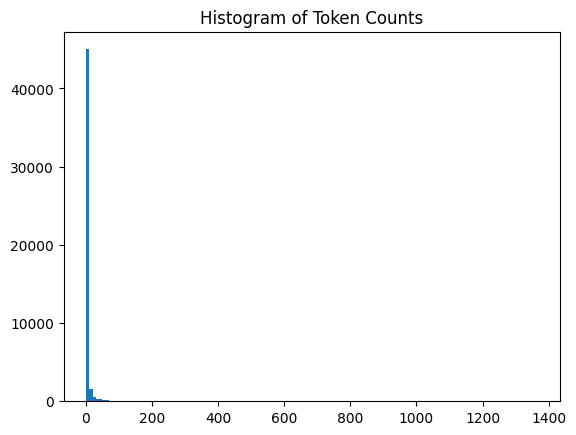

,count
count,48691.000000
mean,5.687889
std,27.717476
min,1.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,1365.000000


In [6]:
with open('/content/PCA/05_PCA/all_tokens.pickle', 'rb') as file:
    all_tokens = pickle.load(file)

from collections import Counter
token_count = Counter(all_tokens)
token_freq = token_count.most_common()

all_df = pd.DataFrame(token_freq, columns=['token','count'])
plt.hist(all_df['count'], bins=140)
plt.title("Histogram of Token Counts")
plt.show()

all_df['count'].describe()

The overwhelming majority of tokens occur 0-10 times in the entire dataset. However, there are some that occur >10 times in the dataset, which is what will affect the outcome of a predictive algorithm. The maximum number of occurences is 1,365 times, which is pretty astounding.

##Question 3

In [2]:
df = pd.read_parquet('/content/PCA/05_PCA/Phishing_clean.parquet')

# Part 1
y = df['Email Type']
X = df.drop('Email Type',axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2, random_state=2024)

In [3]:
# Part 2
lm3 = LinearRegression(fit_intercept=False).fit(X_train, y_train)
y_hat_test = lm3.predict(X_test)
y_hat_train = lm3.predict(X_train)
print('R^2 train: ', r2_score(y_hat_train, y_train))
print('R^2 test: ', r2_score(y_hat_test, y_test))

R^2 train:  0.6253144530724517
R^2 test:  -0.00039048326375090703


The R^2 on the training set is 0.63 and on the test set is ~0.

In [4]:
# Part 3
df3 = pd.DataFrame({'variable':lm3.feature_names_in_ , 'value':lm3.coef_})
df3['abs'] = np.abs(df3['value'])
df3.sort_values('abs', ascending=False)

,variable,value,abs
6,2002,1.497790e+13,1.497790e+13
668,500,-8.193551e+12,8.193551e+12
1269,dysfunction,7.307862e+12,7.307862e+12
1302,erectile,-7.307862e+12,7.307862e+12
237,1999,-5.405713e+12,5.405713e+12
...,...,...,...
2453,timing,-1.831055e-04,1.831055e-04
978,van,-1.373291e-04,1.373291e-04
2527,cleburne,-9.155273e-05,9.155273e-05
118,even,-8.392334e-05,8.392334e-05


The largest coefficients all belong to numbers, which isn't very interpretable in this context.

## Question 4

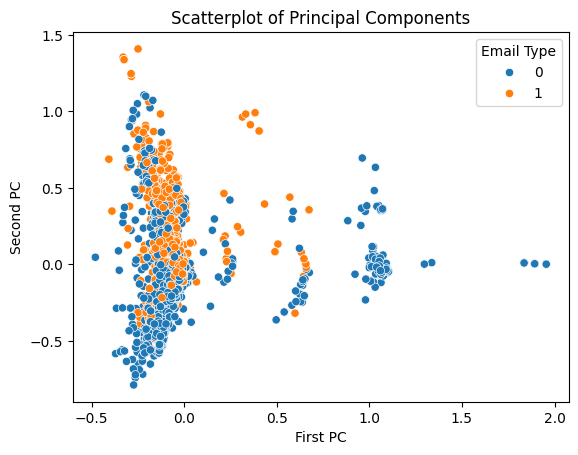

In [5]:
pca_result = PCA(n_components=2).fit(X_train)
pc_train = pca_result.transform(X_train)
pc_test = pca_result.transform(X_test)
sns.scatterplot(x=pc_test[:,0], y=pc_test[:,1], hue=y_test)
plt.title("Scatterplot of Principal Components")
plt.xlabel("First PC")
plt.ylabel("Second PC")
plt.show()

The phishing emails tend to have a higher second PC and a low first PC. The safe emails tend to have a lower second PC and also a low first PC, although the safe emails have much more variation in the first PC, so the maximum is much higher than for the phishing emails.

##Question 5

In [6]:
pca_result = PCA(n_components=2610).fit(X_train)
pc_train = pca_result.transform(X_train)
pc_test = pca_result.transform(X_test)

lm5 = LinearRegression().fit(pc_train,y_train)
y_hat_test = lm5.predict(pc_test)
y_hat_train = lm5.predict(pc_train)

print('R^2 train: ', r2_score(y_hat_train, y_train) )
print('R^2 test: ', r2_score(y_hat_test, y_test) )

R^2 train:  0.691663670180082
R^2 test:  0.5916424391049376


The R^2 on the training set is approximately the same, as expected, but the R^2 on the test set is much higher than it was with the first linear regression model. This means that this model, using PCA, has much better predictive power than a simple linear regression model does for this dataset.

##Question 6

The original data likely has a lot of multicollinearity, which means that it won't perform well in a predictive model. PCA accounts for this multicollinearity and produces variables that represent all of the original predictors' effects, while not being correlated to one another. This makes prediction much more accurate. PCA also allows you to optimize the number of components for the best possible model. The biggest drawback with PCA is that these components are not quite explainable in the way the original variables are. The model will predict well, but we can't draw any conclusions about any specific variables. Furthermore, the more components added to the model, the less interpretable it becomes.